In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [48]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [49]:
# READ THE FILE INTO A DATAFRAME
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")

In [50]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,...,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,...,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,...,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,...,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,...,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,...,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [51]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)
X = df["REVIEW_TEXT"]
y = df['LABEL']

In [30]:
df.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].str.replace(' days', '')
df['TIMESTAMP_DIFFERENCE'] = df['TIMESTAMP_DIFFERENCE'].astype(int)
num_features = df.drop(['ID','USER_ID','PRODUCT_ID','DATE','REVIEW_TEXT','LABEL'],axis=1)

In [52]:
# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df['REVIEW_TEXT'] , df['LABEL'], test_size=0.25, random_state=42)

# print('X_train.shape:', X_train.shape)

# print('X_test.shape', X_test.shape)

In [53]:
print(X)

0                                                    great
1        family bubbys brunch saturday morning got 10am...
2        really like place need get menu sorted finally...
3        one favorite places us awesome reservations pl...
4        make sure go small group friends like share fo...
                               ...                        
19935    arrived towards end brunch period items lookin...
19936    seemed matter looked places go brooklyn traif ...
19937    grabbed couple friends walked 8pm saturday nig...
19938    super excited try xixa sister restaurant traif...
19939    halal cart defines food cooked served bunch hu...
Name: REVIEW_TEXT, Length: 19940, dtype: object


In [33]:
# Load pre-trained GloVe embeddings
# Replace 'glove.6B.100d.txt' with the path to your GloVe embeddings file
glove_model = KeyedVectors.load_word2vec_format('../../Fake review detection dataset/glove.6B.200d.txt',binary=False, no_header=True)

In [54]:
# Function to convert reviews to GloVe embeddings
def glove_average(glove_model, words):
    all_words, mean = set(), []
    
    for word in words:
        if word in glove_model:
            mean.append(glove_model[word])
            all_words.add(word)

    if not mean:
        return np.zeros(glove_model.vector_size,)

    mean = np.array(mean).mean(axis=0)
    return mean

def glove_average_list(glove_model, text_list):
    return np.vstack([glove_average(glove_model, post) for post in text_list])

# Transform text to GloVe embeddings
X_glove_average = glove_average_list(glove_model, X)

In [63]:
print(X_glove_average.shape)
print(X_glove_average)

(19940, 200)
[[ 0.12592301  0.38734999 -0.34513119 ...  0.0854564   0.22607
   0.59023178]
 [ 0.07226516  0.58635205 -0.21730159 ...  0.13291055  0.40193781
   0.51098299]
 [ 0.06927717  0.5271973  -0.23108317 ...  0.12668566  0.34384975
   0.5246219 ]
 ...
 [ 0.07360698  0.55180877 -0.23539355 ...  0.12176675  0.38920218
   0.49088639]
 [ 0.08970677  0.53066397 -0.25255951 ...  0.13224433  0.34845641
   0.51039362]
 [ 0.0998597   0.55787319 -0.2380393  ...  0.11985116  0.39054695
   0.49191454]]


In [56]:
# Apply ADASYN for balancing classes
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_glove_average, y)

In [57]:
print(X_resampled.shape)
print(X_test.shape)
print(y_resampled.shape)
print(y_test.shape)

(35331, 200)
(4985,)
(35331,)
(4985,)


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [59]:
# Create a pipeline
model = LogisticRegression()

# Fit the model
model.fit(X_train, y_train)

LogisticRegression()

In [60]:
# Make predictions
y_pred = model.predict(X_test)

In [61]:
print(y_test.shape)
print(y_pred.shape)

(7067,)
(7067,)


In [62]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5803028159049102
Confusion Matrix:
 [[1814 1646]
 [1320 2287]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.58      0.52      0.55      3460
           1       0.58      0.63      0.61      3607

    accuracy                           0.58      7067
   macro avg       0.58      0.58      0.58      7067
weighted avg       0.58      0.58      0.58      7067



In [43]:
# Predict probabilities for test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

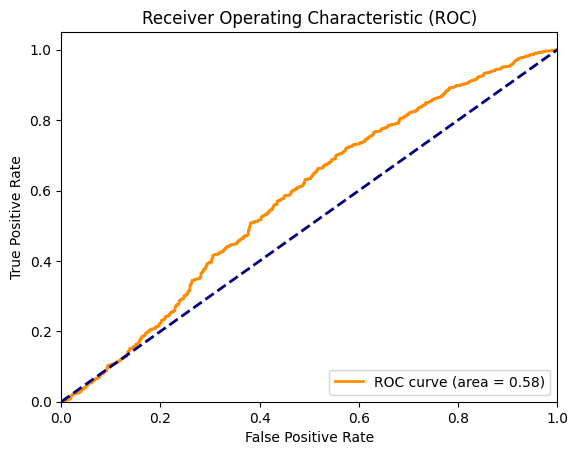

In [44]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [45]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Print sensitivity and specificity
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.6280107047279215
Specificity (True Negative Rate): 0.5089820359281437
